In [3]:
# For embedding audio player
import IPython

# Plots
import matplotlib.pyplot as plt
from pylab import plot, show, figure, imshow
plt.rcParams['figure.figsize'] = (15, 6)

import numpy
import essentia.standard as es

In [2]:
!pip install essentia
!pip install mir_eval
!pip install midiutil

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.7/13.7 MB 67.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.7/90.7 kB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for mir_eval: filename=mir_eval-0.7-py3-none-any.whl size=100705 sha256=58845714a04bc9a60bc787d4f1ad6f2f4b72062202b37c4e631fb239643448ab
  Stored in directory: /root/.cache/pip/wheels/3e/2f/0d/dda9c4c77a170e21356b6afa2f7d9bb078338634ba05d94e3f
Successfully built mir_eval
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 14.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for midiutil: filename=MIDIUtil-1.2.1-py3-none-any.whl size=54567 sha256=91cd

In [60]:
audiofile = 'song2.wav'

loader = es.EqloudLoader(filename=audiofile, sampleRate=44100)
audio = loader()

pitch_extractor = es.PredominantPitchMelodia(frameSize = 2048, hopSize = 1024, guessUnvoiced = True)
pitch_values, pitch_confidence = pitch_extractor(audio)

pitch_times = numpy.linspace(0.0,len(audio)/44100.0,len(pitch_values))

Duration of the audio sample [sec]:
130.0104081632653


In [61]:
from mir_eval.sonify import pitch_contour

synthesized_melody = pitch_contour(pitch_times, pitch_values, 44100).astype(numpy.float32)[:len(audio)]
es.AudioWriter(filename='melody.mp3', format='mp3')(es.StereoMuxer()(synthesized_melody, audio))

IPython.display.Audio('melody.mp3')

In [62]:

data = transform_to_melody_data(pitch_values, pitch_times)

data[30:60]

[(466.16965, 0.023216144314868736),
 (466.16965, 0.023216144314868847),
 (466.16965, 0.023216144314868847),
 (460.8152, 0.023216144314868736),
 (471.58633, 0.023216144314868847),
 (460.8152, 0.023216144314868736),
 (466.16965, 0.023216144314868847),
 (471.58633, 0.023216144314868847),
 (458.1611, 0.023216144314868736),
 (471.58633, 0.023216144314868847),
 (460.8152, 0.023216144314868847),
 (458.1611, 0.023216144314868736),
 (471.58633, 0.023216144314868847),
 (458.1611, 0.023216144314868847),
 (0.0, 0.023216144314868847),
 (0.0, 0.023216144314868625),
 (0.0, 0.023216144314868847),
 (0.0, 0.023216144314868847),
 (0.0, 0.023216144314868847),
 (0.0, 0.023216144314868847),
 (0.0, 0.023216144314868625),
 (0.0, 0.023216144314868847),
 (0.0, 0.023216144314868847),
 (0.0, 0.023216144314868847),
 (339.29004, 0.023216144314868847),
 (347.2206, 0.023216144314868847),
 (353.28995, 0.023216144314868625),
 (349.23206, 0.023216144314868847),
 (347.2206, 0.023216144314868847),
 (351.25513, 0.023216144

In [63]:
import numpy
import essentia.standard as es
import librosa

from midiutil import MIDIFile


def transform_to_melody_data(pitch_values, pitch_times):
  return [(pitch_values[i], pitch_times[i+1]-pitch_times[i]) for i in range(len(pitch_values)-1)]


def remove_duplicates(a, min_freq=0.1, min_note_length=0.05):

  ans = []
  dur = 0
  for i in range(len(a)-1):
    dur += a[i][1]

    current_note = librosa.hz_to_note(a[i][0]) if a[i][0] >= min_freq else 'N'
    next_note = librosa.hz_to_note(a[i+1][0]) if a[i+1][0] >= min_freq else 'N'

    if current_note != next_note:
      ans.append((current_note, dur))
      dur = 0
      
  if a[-1][0] >= min_freq:
    ans.append((librosa.hz_to_note(a[-1][0]), a[-1][1]+dur))

  ans = [e if e[1] >= min_note_length else ('N', e[1]) for e in ans]

  return ans


def save_notes_as_midi(note_data, BPM=60):

    track = 0
    channel = 0
    time = 0  # In beats
    volume = 100  # 0-127, as per the MIDI standard
    midi_file = MIDIFile(4)
    midi_file.addTempo(track, time, BPM)

    for note, duration in note_data:
        
        beat_duration = duration * (BPM/60)
        # beat_duration = duration

        if note != 'N':
          midi_file.addNote(track, channel, librosa.note_to_midi(note), time, beat_duration, volume)
          
        time += beat_duration

    with open("result.mid", "wb") as output_file:
        midi_file.writeFile(output_file)



audiofile = 'path_to_audio'

loader = es.EqloudLoader(filename=audiofile, sampleRate=44100)
audio = loader()

pitch_extractor = es.PredominantPitchMelodia(frameSize = 2048, hopSize = 1024, guessUnvoiced = True)
pitch_values, _ = pitch_extractor(audio)

pitch_times = numpy.linspace(0.0,len(audio)/44100.0,len(pitch_values))

melody_data = transform_to_melody_data(pitch_values, pitch_times)
melody_data = remove_duplicates(melody_data, min_freq=20, min_note_length=0.12) # Обработали melody_data, на этом можно обучаться как на chord_data

save_notes_as_midi(melody_data) # Если хочется послушать, что предсказали

In [48]:
data[0][1]

0.023219086004036056

In [66]:
new_data = remove_duplicates(data, min_freq=30, min_note_length=0.12)

In [54]:
# For embedding audio player
import IPython

# Plots
import matplotlib.pyplot as plt
from pylab import plot, show, figure, imshow
plt.rcParams['figure.figsize'] = (15, 6)

import numpy
import essentia.standard as es

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [67]:
from midiutil import MIDIFile
import librosa
def save_notes_as_midi(note_data, BPM=60):

    track = 0
    channel = 0
    time = 0  # In beats
    volume = 100  # 0-127, as per the MIDI standard
    midi_file = MIDIFile(4)
    midi_file.addTempo(track, time, BPM)

    for note, duration in note_data:
        
        beat_duration = duration * (BPM/60)
        # beat_duration = duration

        if note != 'N':
          midi_file.addNote(track, channel, librosa.note_to_midi(note), time, beat_duration, volume)
          
        time += beat_duration

    with open("result.mid", "wb") as output_file:
        midi_file.writeFile(output_file)

save_notes_as_midi(new_data, 60)

In [59]:
new_data

[('N', 0.8823252681533701),
 ('C4', 0.4411626340766851),
 ('C3', 0.0928763440161442),
 ('N', 0.3250672040565048),
 ('D4', 0.464381720080721),
 ('N', 0.3482862900605408),
 ('D4', 0.6036962361049376),
 ('N', 0.23219086004036082),
 ('C4', 0.1625336020282524),
 ('N', 0.6501344081130096),
 ('C4', 0.4179435480726488),
 ('N', 0.023219086004035994),
 ('C4', 0.11609543002017997),
 ('N', 0.3250672040565048),
 ('N', 0.023219086004035994),
 ('C4', 0.11609543002018086),
 ('N', 0.6733534941170456),
 ('D4', 0.23219086004036082),
 ('N', 1.3699260742381272),
 ('N', 0.023219086004035994),
 ('N', 0.023219086004035994),
 ('C4', 0.3250672040565048),
 ('N', 3.320329298577156),
 ('N', 0.023219086004035105),
 ('N', 0.023219086004036882),
 ('D4', 0.16253360202825284),
 ('N', 1.9039650523309568),
 ('G3', 0.20897177403632305),
 ('N', 0.023219086004036882),
 ('N', 0.04643817200807199),
 ('N', 0.3947244620686128),
 ('A3', 0.09287634401614397),
 ('G♯3', 0.09287634401614397),
 ('N', 0.023219086004036882),
 ('N', 0.0

In [75]:
onsets, durations, notes = es.PitchContourSegmentation(hopSize=1024, minDuration=0.1)(pitch_values, audio)
[(midi_to_note(note), duration) for note, duration in zip(notes, durations)][:20]

[('C4', 0.41795918),
 ('C3', 0.04643991),
 ('D4', 0.44117913),
 ('D4', 0.5804989),
 ('C4', 0.13931973),
 ('C4', 0.39473924),
 ('C4', 0.09287982),
 ('C♯4', 0.116099775),
 ('D4', 0.20897959),
 ('D4', 0.09287982),
 ('C4', 0.20897959),
 ('D♯4', 0.18575963),
 ('G3', 0.2554195),
 ('A3', 0.09287982),
 ('G♯3', 0.04643991),
 ('C4', 0.04643991),
 ('C4', 0.06965987),
 ('G3', 0.18575963),
 ('G2', 0.09287982),
 ('G3', 0.116099775)]

In [69]:
import mido

PPQ = 48 # Pulses per quarter note.
BPM = 120 # Assuming a default tempo in Ableton to build a MIDI clip.
tempo = mido.bpm2tempo(BPM) # Microseconds per beat.

# Compute onsets and offsets for all MIDI notes in ticks.
# Relative tick positions start from time 0.
offsets = onsets + durations
silence_durations = list(onsets[1:] - offsets[:-1]) + [0]

mid = mido.MidiFile()
track = mido.MidiTrack()
mid.tracks.append(track)

for note, onset, duration, silence_duration in zip(list(notes), list(onsets), list(durations), silence_durations):
    track.append(mido.Message('note_on', note=int(note), velocity=64,
                              time=int(mido.second2tick(duration, PPQ, tempo))))
    track.append(mido.Message('note_off', note=int(note),
                              time=int(mido.second2tick(silence_duration, PPQ, tempo))))

midi_file = 'extracted_melody.mid'
mid.save(midi_file)
print("MIDI file location:", midi_file)

MIDI file location: extracted_melody.mid


In [66]:
!pip install mido

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.1/51.1 kB 4.4 MB/s eta 0:00:00


In [54]:
from midiutil import MIDIFile
from librosa import hz_to_midi

def save_melody_as_midi(notes, durations, onsets, BPM=60):

    track = 0
    channel = 0
    time = 0  # In beats
    volume = 100  # 0-127, as per the MIDI standard
    midi_file = MIDIFile(4)
    midi_file.addTempo(track, time, BPM)

    for note, duration, onset in zip(notes, durations, onsets):

      beat_duration = duration * (BPM/60)
      midi_file.addNote(track, channel, int(note), onset, beat_duration, volume)
      

    # return midi_file
    with open("result.mid", "wb") as output_file:
        midi_file.writeFile(output_file)

save_melody_as_midi(notes, durations, onsets, 72)
# with open("result.mid", "wb") as output_file:
#     midi.writeFile(output_file)

B3 0.06385487
D4 0.05514739
D4 0.07256236
C4 0.017414967
C4 0.066757366
C♯4 0.014512472
D4 0.026122449
C4 0.043537416
D♯4 0.023219954
G3 0.031927437
A♯3 0.049342405
E3 0.04063492
G3 0.014512472
C4 0.043537416
D♯4 0.14802721
D4 0.017414967
G3 0.011609977
F♯4 0.11029478
D♯4 0.04063492
D4 0.026122449
C♯4 0.08417234
F3 0.031927437
F3 0.014512472
C4 0.029024944
G3 0.14802721
C♯3 0.06095238
D4 0.13061224
D♯4 0.08126984
C♯4 0.06965987
E4 0.058049887
E4 0.06095238
E4 0.023219954
D4 0.014512472
E4 0.023219954
C♯4 0.09578231
F♯3 0.18866213
D4 0.037732426
C4 0.09578231
C♯4 0.011609977
E4 0.034829933
G♯4 0.034829933
D♯4 0.026122449
C4 0.13061224
G♯3 0.037732426
D♯4 0.06385487
E4 0.07256236
E4 0.02031746
D4 0.02031746
D♯4 0.029024944
C♯4 0.08707483
D♯3 0.026122449
F3 0.011609977
D♯3 0.017414967
G3 0.06095238
A3 0.06385487
G3 0.07546485
C♯4 0.049342405
D♯4 0.09868481
D4 0.12770975
C4 0.011609977
D4 0.026122449
D♯4 0.09868481
E4 0.10739229
D4 0.014512472
E5 0.011609977
C♯4 0.09868481
A3 0.16834468
C3

In [ ]:
track = 0
channel = 0
time = 0  # In beats
volume = 100  # 0-127, as per the MIDI standard
midi_file = MIDIFile(4)
midi_file.addTempo(track, time, BPM)
midi_file.addNote(track, channel, 56.0, 2, beat_duration, volume)

In [ ]:
m

0

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
print(pitch_values)

[0. 0. 0. ... 0. 0. 0.]


In [ ]:
onsets, durations, notes = es.PitchContourSegmentation()(pitch_values, synthesized_melody)
# print("MIDI notes:", notes) # Midi pitch number
# print("MIDI note onsets:", onsets)
# print("MIDI note durations:", durations)
print(len(notes), len(onsets), len(durations))


140 140 140


In [ ]:
def f(note):
  try:
    return int(note)
  except:
    return 0

In [ ]:
import mido

PPQ = 1 # Pulses per quarter note.
BPM = 56 # Assuming a default tempo in Ableton to build a MIDI clip.
tempo = mido.bpm2tempo(BPM) # Microseconds per beat.

# Compute onsets and offsets for all MIDI notes in ticks.
# Relative tick positions start from time 0.
offsets = onsets + durations
silence_durations = list(onsets[1:] - offsets[:-1]) + [0]

mid = mido.MidiFile()
track = mido.MidiTrack()
mid.tracks.append(track)

for note, onset, duration, silence_duration in zip(list(notes), list(onsets), list(durations), silence_durations):
    track.append(mido.Message('note_on', note = f(note), velocity=64,
                              time=int(mido.second2tick(duration, PPQ, tempo))))
    track.append(mido.Message('note_off', note = f(note),
                              time=int(mido.second2tick(silence_duration, PPQ, tempo))))

midi_file = 'extract_melody17.mid'
mid.save(midi_file)
print("MIDI file location:", midi_file)

MIDI file location: extract_melody17.mid


In [ ]:
pip install pretty-midi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 36.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pretty-midi: filename=pretty_midi-0.2.10-py3-none-any.whl size=5592289 sha256=939e450c118f33473023370a9983335f6e331080495951d682b990f7be1cc617
  Stored in directory: /root/.cache/pip/wheels/cd/a5/30/7b8b7f58709f5150f67f98fde4b891ebf0be9ef07a8af49f25
Successfully built pretty-midi


In [ ]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
import pretty_midi

# Загрузка аудиофайла с помощью librosa
audio_file = '/content/flamenco_melody.mp3'
y, sr = librosa.load(audio_file, sr = 44100)

# Создание хромограммы с помощью librosa
chroma = librosa.feature.chroma_cqt(y=y, sr=sr)

# Визуализация хромограммы
# plt.figure(figsize=(10, 4))
# librosa.display.specshow(chrom1, y_axis='chroma', x_axis='time')
# plt.colorbar()
# plt.title('Chromagram')
# plt.tight_layout()
# plt.show()

# Создание объекта PrettyMIDI
midi = pretty_midi.PrettyMIDI()

# Создание инструмента и добавление хромограммы в MIDI-файл
instrument = pretty_midi.Instrument(program=pretty_midi.instrument_name_to_program('Acoustic Grand Piano'))

# Преобразование хромограммы в MIDI-ноты
for t, pitches in enumerate(chrom1.T):
    for pitch, intensity in enumerate(pitches):
        if intensity > 0:
            note = pretty_midi.Note(
                velocity=int(intensity * 127),
                pitch=pitch + pretty_midi.note_name_to_number('C2'),
                start=t * 0.01,
                end=(t + 1) * 0.01
            )
            instrument.notes.append(note)

# Добавление инструмента в MIDI-файл
midi.instruments.append(instrument)

# Сохранение MIDI-файла
output_midi_file = 'file2.mid'
midi.write(output_midi_file)


In [ ]:
chrom1 = chroma
for i in range(len(chroma)):
  for j in range(len(chroma[i])):
    if(chrom1[i][j] != 1):
      chrom1[i][j] = 0
  

In [ ]:
import librosa
import numpy as np
import pretty_midi

# Load chromagram CQT from file or compute it using librosa
chromagram = chrom1

# Define threshold value
threshold = 0.5

# Define time steps
time_steps = chromagram.shape[1]

# Define MIDI pitch range
min_midi_pitch = 21  # MIDI note A0
max_midi_pitch = 108  # MIDI note C8

# Create PrettyMIDI object
midi_data = pretty_midi.PrettyMIDI()

# Create MIDI instrument
instrument = pretty_midi.Instrument(program=pretty_midi.instrument_name_to_program('Acoustic Grand Piano'))

# Iterate over time steps
for t in range(time_steps):
    # Determine active frequencies
    active_freqs = np.where(chromagram[:, t] > threshold)[0]

    # Convert active frequencies to MIDI pitches
    midi_pitches = active_freqs + min_midi_pitch

    # Calculate the duration of the time step
    duration = librosa.samples_to_time(1, sr=sr)

    # Create MIDI events for each active note
    for pitch in midi_pitches:
        note = pretty_midi.Note(
            velocity=100,
            pitch=pitch,
            start=t * duration,
            end=(t + 1) * duration
        )
        instrument.notes.append(note)

# Add the instrument to the MIDI track
midi_data.instruments.append(instrument)

# Save the MIDI file
midi_data.write('output2.mid')


In [39]:
from mir_eval.sonify import pitch_contour

# Essentia operates with float32 ndarrays instead of float64, so let's cast it.
synthesized_melody = pitch_contour(pitch_times, pitch_values, 44100).astype(numpy.float32)[:len(audio)]
es.AudioWriter(filename='melody.wav', format='wav')(es.StereoMuxer()(synthesized_melody, synthesized_melody))

<ipython-input-48-cba8053f944b>:11: UserWarning: Trying to display complex-valued input. Showing magnitude instead.
  librosa.display.specshow(chromagram, x_axis='time', y_axis='chroma', cmap='coolwarm')


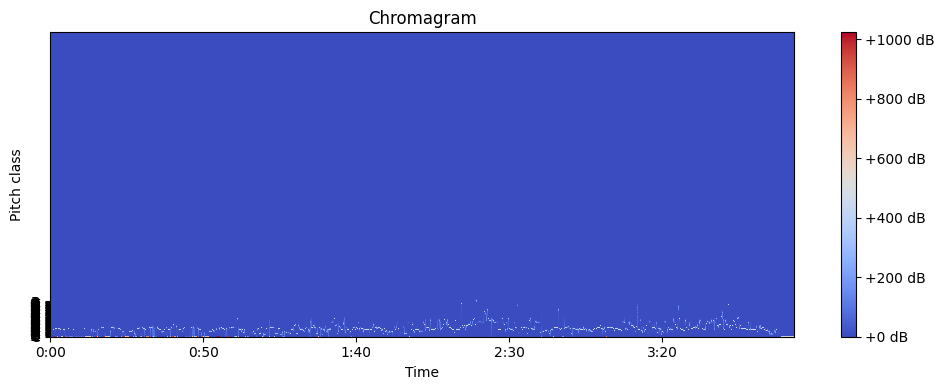

In [48]:
import librosa
y, sr = librosa.load("melody.wav")

melody = librosa.feature.melspectrogram(y=y, sr=sr)

# Compute the chromagram
chromagram = librosa.stft(y)

# Plot the heat chromagram
plt.figure(figsize=(10, 4))
librosa.display.specshow(chromagram, x_axis='time', y_axis='chroma', cmap='coolwarm')
plt.colorbar(format='%+2.0f dB')
plt.title('Chromagram')
plt.tight_layout()
plt.show()